In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from datetime import datetime
from matplotlib.patches import Ellipse, Rectangle
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
test_init()

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

<h2>Manual Gating</h2>

In [108]:
def visualise_manual_ellipse(hc, parent_population, x, y, centroid, width, height, angle, xlim, ylim):
    data = apply_transform(hc.get_population_df(parent_population).copy(), [x, y], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()
    
def visualise_manual_threshold(sample_go, parent_population, x, t, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data['SSC-A'], bins=500, norm=LogNorm())
    ax.axvline(t, c='r')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

def visualise_manual_rect(sample_go, parent_population, x, y, x_min, x_max, y_min, y_max, xlim, ylim):
    data = apply_transform(sample_go.get_population_df(parent_population).copy(), [x, y], 'logicle')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    r = Rectangle(xy=(x_min, y_min), width=x_max, height=y_max, fill=False, edgecolor='r')
    ax.add_patch(r)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [23]:
def debris_gate(hc):
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('cells', definition='+')
    child_populations.add_population('debris', definition='-')
    gate_definition = dict(x='FSC-A', y='SSC-A')
    hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                    kwargs=gate_definition, child_populations=child_populations)
    hc.apply('debris_gate', plot_output=False)
    hc.save(overwrite=True)

In [24]:
for x in samples:
    hc = Gating(exp, x)
    print(f'Precprocessing for {x}...')
    debris_gate(hc)
print('Complete!')

Precprocessing for hc1...
Saved successfully!
Precprocessing for hc4...
Saved successfully!
Precprocessing for hc5...
Saved successfully!
Precprocessing for hc7...
Saved successfully!
Precprocessing for hc9...
Saved successfully!
Precprocessing for hc10...
Saved successfully!
Precprocessing for hc11...
Saved successfully!
Precprocessing for hc12...
Saved successfully!
Precprocessing for hc13...
Saved successfully!
Complete!


In [28]:
for x in ['hc15', 'hc16', 'hc17', 'hc18', 'hc19']:
    hc = Gating(exp, x)
    print(f'Precprocessing for {x}...')
    debris_gate(hc)
print('Complete!')

Precprocessing for hc15...
Saved successfully!
Precprocessing for hc16...
Saved successfully!
Precprocessing for hc17...
Saved successfully!
Precprocessing for hc18...
Saved successfully!
Precprocessing for hc19...
Saved successfully!
Complete!


<h3>Lymphocytes</h3>

In [97]:
hc = Gating(exp, 'hc19')

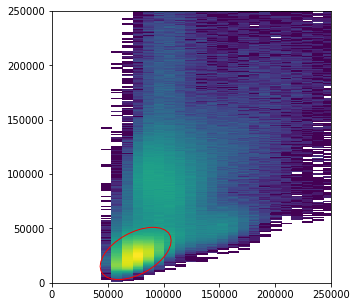

In [100]:
centroid=(75000, 27000)
width=70000
height=38000
angle=30
visualise_manual_ellipse(hc, centroid, width, height, angle, xlim=(0, 250000), ylim=(0,250000))

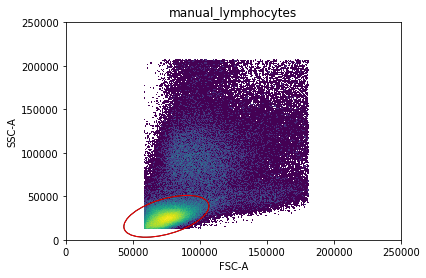

In [101]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

gate_definition = dict(x='FSC-A', y='SSC-A', centroid=centroid, width=width, height=height, angle=angle,
                      transform_x=None, transform_y=None)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)
hc.apply('manual_lymphocytes')

In [102]:
hc.save(overwrite=True)

Saved successfully!


True

<h3>Live CD3</h3>

In [174]:
hc = Gating(exp, 'hc19')

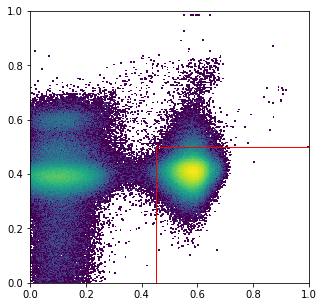

In [175]:
x_min, x_max, y_min, y_max = 0.45, 1.0, 0, 0.5
visualise_manual_rect(hc, 'manual_lymphocytes', 'CD3', 'L/D', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

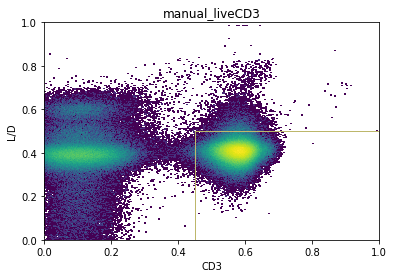

In [176]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_liveCD3', definition='+')
child_populations.add_population('manual_liveCD3_Neg', definition='-')

gate_definition = dict(x='CD3', y='L/D', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_liveCD3', parent='manual_lymphocytes', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)
hc.apply('manual_liveCD3')

In [177]:
hc.save(overwrite=True)

Saved successfully!


True

<h3>GDT Cells</h3>

In [270]:
hc = Gating(exp, 'hc19')

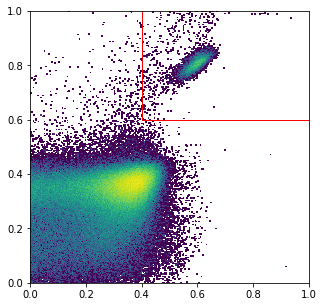

In [271]:
x_min, x_max, y_min, y_max = 0.4, 1.0, 0.6, 1.0
visualise_manual_rect(hc, 'manual_liveCD3', 'PanGD', 'Vd2', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

In [272]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_gdt', definition='+')
child_populations.add_population('manual_gdtNEG', definition='-')
gate_definition = dict(x='PanGD', y='Vd2', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_gdt', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)
hc.apply('manual_gdt')

Error: gate with name manual_gdt already exists.
Error: population manual_gdt already exists, if you wish to overwrite this population please remove it with the remove_population method and then try again


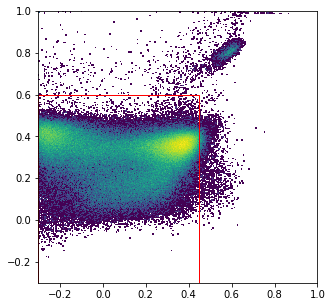

In [267]:
x_min, x_max, y_min, y_max = -0.3, 0.75, -0.3, 0.9
visualise_manual_rect(hc, 'manual_liveCD3', 'PanGD', 'Vd2', x_min, x_max, y_min, y_max, 
                      xlim=(-0.3,1), ylim=(-0.3,1))

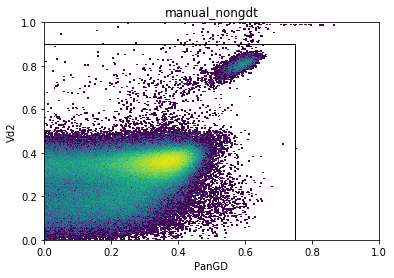

In [268]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_nongdt', definition='+')
child_populations.add_population('manual_nongdtNEG', definition='-')
gate_definition = dict(x='PanGD', y='Vd2', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_nongdt', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)
hc.apply('manual_nongdt')

In [269]:
hc.save(overwrite=True)

Saved successfully!


True

<h2>Automated Gates</h2>

In [4]:
def lymphocyte_gate(hc):
    # GMM
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_lymphocytes', definition='+')
    child_populations.add_population('gmm_lymphocytes_NEG', definition='-')
    pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
    gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                          conf=0.99, transform_x=None, transform_y=None)
    hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                    kwargs=gate_definition, child_populations=child_populations)
    hc.apply('gmm_lymphocytes', plot_output=False)
    
    #DBSCAN
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_lymphocytes', target=(70000, 40000), weight=1)
    gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10,
                          transform_x=None, transform_y=None)
    hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                     method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dbscan_lymphocytes', plot_output=False)
    
    #HDBSCAN
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
    gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2,
                           transform_x=None, transform_y=None)
    hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                     method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('hdbscan_lymphocytes', plot_output=False)
    
    #DENS2D
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_lymphocytes', definition='--')
    child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
    gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=1000,
                           transform_x=None, transform_y=None)
    hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dens2d_lymphocytes', plot_output=False)
    hc.save(overwrite=True)

In [5]:
def liveCD3_gate(hc):
    #GMM
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_liveCD3', definition='+')
    child_populations.add_population('gmm_liveCD3_NEG', definition='-')
    gate_definition = dict(x='CD3', y='L/D', target=(0.6, 0.4), k=3, conf=0.99)
    hc.create_gate(gate_name='gmm_liveCD3', parent='manual_lymphocytes', class_='MixtureModel', method='gate',
                    kwargs=gate_definition, child_populations=child_populations)
    hc.apply('gmm_liveCD3', plot_output=False)
    
    #DBSCAN
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_liveCD3', target=(0.6, 0.4), weight=1)
    gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, distance_nn=0.01, frac=0.1,nn=10)
    hc.create_gate(gate_name='dbscan_liveCD3', parent='manual_lymphocytes', 
                   class_='DensityBasedClustering', method='dbscan',
                   kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dbscan_liveCD3', plot_output=False)
    
    #HDBSCAN
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_liveCD3', target=(0.6, 0.4), weight=1)
    gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, frac=0.1)
    hc.create_gate(gate_name='hdbscan_liveCD3', parent='manual_lymphocytes', class_='DensityBasedClustering', 
                     method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('hdbscan_liveCD3', plot_output=False)
    
    #DENS2D
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_liveCD3', definition=['+-'])
    child_populations.add_population('dens2d_liveCD3_Neg', definition=['++', '--', '-+'])
    gate_definition = dict(x='CD3', y='L/D', kde_bw=0.05, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_liveCD3', parent='manual_lymphocytes', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dens2d_liveCD3', plot_output=False)
    hc.save(overwrite=True)

In [6]:
def gdt_gate(hc):
    #GMM
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_gdt', definition='+')
    child_populations.add_population('gmm_gdtNEG', definition='-')

    pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                          k=2)
    hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                    kwargs=gate_definition, child_populations=child_populations)
    hc.apply('gmm_gdt', plot_output=False)
    
    #DBSCAN
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                          downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dbscan_gdt', plot_output=False)
    
    #HDBSCAN
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('hdbscan_gdt', plot_output=False)
    
    #DENS2D
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_gdt', definition=['++'])
    child_populations.add_population('dens2d_nongdt', definition=['--'])
    child_populations.add_population('dens2d_vd2', definition=['-+'])
    child_populations.add_population('dens2d_noise', definition=['+-'])
    gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dens2d_gdt', plot_output=False)
    hc.save(overwrite=True)

In [8]:
samples

['hc1',
 'hc4',
 'hc5',
 'hc7',
 'hc9',
 'hc10',
 'hc11',
 'hc12',
 'hc13',
 'hc15',
 'hc16',
 'hc17',
 'hc18',
 'hc19']

In [9]:
for x in ['hc15', 'hc16', 'hc17', 'hc18', 'hc19']:
    hc = Gating(exp, x)
    print(f'------------------------ {x} ------------------------')
    print('Lymphocyte gating...')
    lymphocyte_gate(hc)
    print('Live CD3 gating...')
    liveCD3_gate(hc)
    print('GDT gating...')
    gdt_gate(hc)
    print('-------------------------------------------------------')

------------------------ hc15 ------------------------
Lymphocyte gating...
Saved successfully!
Live CD3 gating...
Saved successfully!
GDT gating...
Expected 3 populations but found 2
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
Expected 3 populations but found 2
Populations f['hdbscan_nongdt', 'hdbscan_vd2'] assigned to the same cluster 1;prioritising hdbscan_nongdt based on weighting.
Saved successfully!
-------------------------------------------------------
------------------------ hc16 ------------------------
Lymphocyte gating...
Saved successfully!
Live CD3 gating...
Saved successfully!
GDT gating...
Expected 3 populations but found 2
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
Expected 3 populations but found 2
Populations f['hdbscan_nongdt', 'hdbscan_vd2'] assigned to the same cluster 2;prioritising hdbscan_nongdt based on

<h2>Performance</h2>

In [22]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
gating_performance = dict(sample_id=[], population=[], method=[], accuracy=[], f1_score=[],
                         precision=[], recall=[], fpr=[])

def check_performance(hc, manual_pop, auto_pop, method):
    try:
        parent = hc.get_population_df(hc.gates[method].parent)
    except KeyError as e:
        print(f'Skipping {method}: {e}')
        return None
    manual_pop_idx = hc.populations[manual_pop].index
    auto_pop_idx = hc.populations[auto_pop].index
    # Apply function and measure time taken
    gating_performance['sample_id'].append(hc.id)
    if manual_pop == 'lymphocytes':
        gating_performance['populations'].append('lymphocytes')
    else:
        gating_performance['population'].append(manual_pop.split('_')[1])
    gating_performance['method'].append(method)
    
    #Pull data
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    
    # Rate performance of result
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    gating_performance['fpr'].append(fp/(fp+tn))

In [ ]:
for x in samples:
    print(f'Assessing performance for {x}')
    hc = Gating(exp, x)
    for method in ['gmm', 'dbscan', 'hdbscan', 'dens2d']:
        auto_pop = f'{method}_lymphocytes'
        check_performance(hc, 'manual_lymphocytes', auto_pop, auto_pop)
        
        auto_pop = f'{method}_liveCD3'
        check_performance(hc, 'manual_liveCD3', auto_pop, auto_pop)
        
        auto_pop = f'{method}_gdt'
        check_performance(hc, 'manual_gdt', auto_pop, auto_pop)
        
        auto_pop = f'{method}_nongdt'
        check_performance(hc, 'manual_nongdt', auto_pop, auto_pop)

In [28]:
def rename_method(x):
    if x.split('_')[0] == 'gmm':
        return 'Gaussian Mixture Model'
    if x.split('_')[0] == 'dbscan':
        return 'DBSCAN'
    if x.split('_')[0] == 'hdbscan':
        return 'HDBSCAN'
    if x.split('_')[0] == 'dens2d':
        return 'Density threshold (2D)'
    return x
def rename_populations(x):
    if x == 'lymphocytes':
        return 'Lymphocytes'
    if x == 'liveCD3':
        return 'Live CD3+'
    if x == 'gdt':
        return 'γδ T cells'
    return x
results = pd.DataFrame(gating_performance)
results['method'] = results['method'].apply(rename_method)
results['population'] = results['population'].apply(rename_populations)

(0, 1)

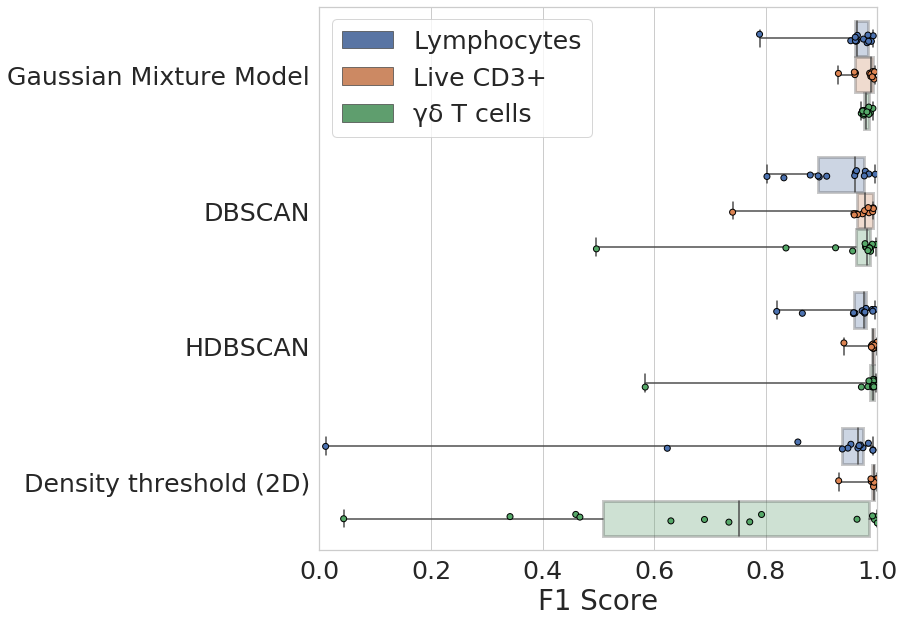

In [57]:
import seaborn as sns
sns.set(font_scale=2.3)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(x="f1_score", y="method", data=results, whis=np.inf, hue='population',
                boxprops=dict(alpha=.3, linewidth=3))
ax = sns.stripplot(x="f1_score", y="method", data=results, hue='population', dodge=True, jitter=True,
                  s=6, edgecolor='black', linewidth=1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:3], labels=labels[:3])
ax.set_xlabel('F1 Score')
ax.set_ylabel('')
ax.set_xlim(0,1)

In [58]:
hc = Gating(exp, 'hc19')
data = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')
auto_gdt_geom = hc.populations['hdbscan_gdt'].geom
x1 = auto_gdt_geom['cords']['x']
y1 = auto_gdt_geom['cords']['y']

auto_nongdt_geom = hc.populations['hdbscan_nongdt'].geom
x2 = auto_nongdt_geom['cords']['x']
y2 = auto_nongdt_geom['cords']['y']

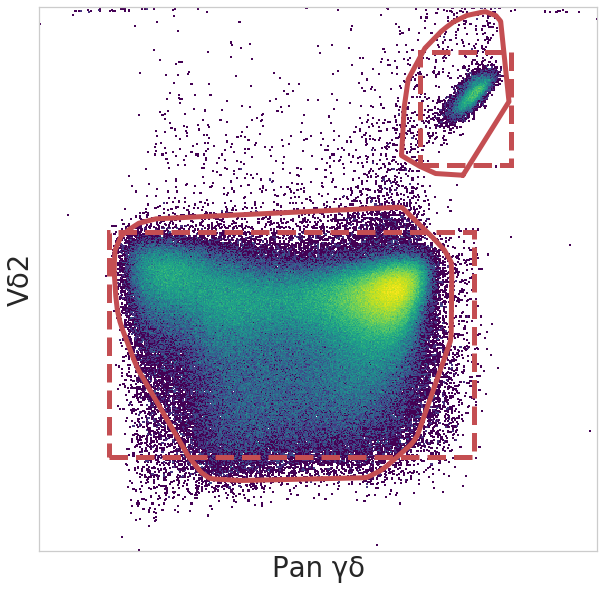

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(data['PanGD'], data['Vd2'], bins=500, norm=LogNorm(), cmap='viridis')
manual_rect = Rectangle(xy=(0.45, 0.65), width=0.25, height=0.25, fill=None, color='r', linestyle='--', linewidth=5)
ax.add_patch(manual_rect)
manual_rect = Rectangle(xy=(-0.4, 0), width=1, height=0.5, fill=None, color='r', linestyle='--', linewidth=5)
ax.add_patch(manual_rect)
ax.plot(x1, y1, '-k', c='r', linewidth=5)
ax.plot(x2, y2, '-k', c='r', linewidth=5)
ax.set_xlabel('Pan γδ')
ax.set_ylabel('Vδ2')
plt.tick_params(
    which='both',
    bottom=False,
    left=False,
    top=False,
    labelbottom=False,
    labelleft=False)
fig.show()

In [115]:
hc = Gating(exp, 'hc19')
data = hc.get_population_df('root')
auto_geom = hc.populations['gmm_lymphocytes'].geom
manual_geom = hc.populations['manual_lymphocytes'].geom

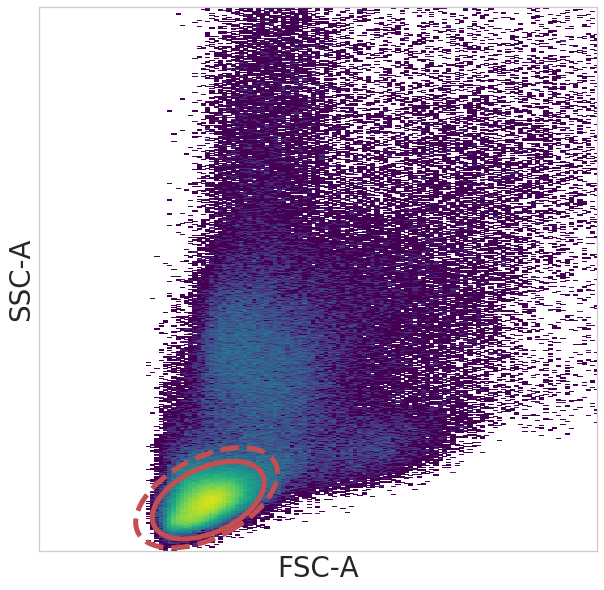

In [119]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(data['FSC-A'], data['SSC-A'], bins=2500, norm=LogNorm(), cmap='viridis')
manual = Ellipse(xy=manual_geom['centroid'],
                 width=manual_geom['width'],
                 height=manual_geom['height'],
                 angle=manual_geom['angle'], 
                 color='r', linestyle='--', linewidth=5, fill=None)
auto = Ellipse(xy=auto_geom['centroid'],
                 width=auto_geom['width'],
                 height=auto_geom['height'],
                 angle=auto_geom['angle'], 
                 color='r', linewidth=5, fill=None)
ax.add_patch(manual)
ax.add_patch(auto)
ax.set_xlabel('FSC-A')
ax.set_ylabel('SSC-A')
plt.tick_params(
    which='both',
    bottom=False,
    left=False,
    top=False,
    labelbottom=False,
    labelleft=False)
ax.set_xlim(0, 250000)
fig.show()